# 1 - Theoretical Foundations of PLS1 Regression


## Introduction and Motivation


Partial Least Squares (PLS) regression is a powerful statistical method used to relate a set of explanatory variables $X \in \mathbb{R}^{N \times P}$ to a response vector $y \in \mathbb{R}^{N}$. It is particularly effective in high-dimensional settings where the number of variables $P$ is much larger than the number of observations $N$ ($P \gg N$).

Unlike Principal Component Regression (PCR), which only considers the variance of $X$, PLS constructs latent variables (or scores) by maximizing the covariance between $X$ and $y$. This ensures that the dimensionality reduction process is directly guided by the target we want to predict.

# 2 - PLS1 algorithm implementation

## 2.1 The Optimization Problem

The core of the PLS1 algorithm (for a univariate response $y$) lies in finding a weight vector $w$ that defines a new direction in the feature space. For the first component, we solve the following convex optimization problem:

$$
\max_w \left( \text{Cov}(Xw, y) \right)^2 \quad \text{subject to} \quad \|w\|_2 = 1
$$

equivalent to : 

$$\max_{w} (y^T X w) \quad \text{subject to} \quad \|w\|_2 = 1$$


We define the Lagrangian $\mathcal{L}$ with the multiplier $\lambda$:
$$ \mathcal{L}(w, \lambda) = y^T X w - \lambda (w^T w - 1) $$

Setting the gradient with respect to $w$ to zero:
$$ \nabla_w \mathcal{L} = X^T y - 2\lambda w = 0 \implies 2\lambda w = X^T y $$

This shows that $w$ is proportional to the cross-product $X^T y$. To satisfy the constraint $\|w\|_2 = 1$, we must normalize this vector:

$$ w = \frac{X^T y}{\|X^T y\|_2} $$

---

### The Iterative NIPALS Algorithm
The **NIPALS** (Non-linear Iterative Partial Least Squares) approach extracts components through a sequence of projections and **deflations**. Before starting, it is assumed that both $X$ and $y$ are mean-centered.

For each component $m = 1, \dots, M$:

1.  **Weight Computation:** Calculate the weight vector $w_m = X_m^T y$.
2.  **Score Construction:** Project the data onto the weights to find the latent score $t_m = X_m w_m$.
3.  **Matrix Deflation:** Remove the information captured by the current component from the data matrix to focus on the remaining variance:
    $$X_{m+1} = X_m - \mathcal{P}_{t_m} X_m$$

> **Note:** $\mathcal{P}_{t_m}$ is the orthogonal projection onto the space spanned by $t_m$. This process ensures that each new component is orthogonal to the previous ones.



---

### Final Regression Coefficients
Once $M$ latent components are extracted, the final model can be expressed in the form of a standard linear regression $y = X\beta + \epsilon$. The PLS regression coefficients are calculated using the weight matrix $W$ and the score matrix $T$:

$$
\hat{\beta}^{PLS} = W(T^{T} T)^{-1} T^{T} y
$$

This coefficient vector $\hat{\beta}^{PLS}$ allows us to map the original high-dimensional space directly to our prediction.


## 2.2 - Implementation of PLS1

In [1]:
class MyPLS1:
    """
    Standard PLS1 implementation using the NIPALS algorithm.
    Focuses on maximizing the covariance between X and a univariate y.
    """
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.beta = None
        self.W = None  # Weights
        self.T = None  # Scores
        self.P = None  # Loadings
        self.q = None  # y-loadings
        self.x_mean = None
        self.y_mean = None

    def fit(self, X, y):
        # 1. Centering the data 
        self.x_mean = np.mean(X, axis=0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(X, axis=0)
        self.y_std = np.std(y)
        X_res = (X - self.x_mean) / self.x_std
        y_res = ((y - self.y_mean).reshape(-1, 1)) / self.y_std

        n_samples, n_features = X.shape
        self.W = np.zeros((n_features, self.n_components))
        self.T = np.zeros((n_samples, self.n_components))
        self.P = np.zeros((n_features, self.n_components))
        self.q = np.zeros(self.n_components)

        for m in range(self.n_components):
            # Step A: Compute weights w (Maximize covariance) 
            # w = X^T * y / ||X^T * y||
            w = X_res.T @ y_res
            w /= np.linalg.norm(w)
            
            # Step B: Compute score t (Latent variable) 
            t = X_res @ w
            
            # Step C: Compute loading p for X 
            # p = (X^T * t) / (t^T * t)
            p = (X_res.T @ t) / (t.T @ t)
            
            # Step D: Compute loading q for y
            q_m = (y_res.T @ t) / (t.T @ t)

            # Store components
            self.W[:, m] = w.flatten()
            self.T[:, m] = t.flatten()
            self.P[:, m] = p.flatten()
            self.q[m] = q_m.item()

            # Step E: Deflation (Remove explained variance)
            X_res = X_res - t @ p.T
            y_res = y_res - t * q_m

        # Compute final regression coefficients Beta 
        # Beta = W * (P^T * W)^-1 * q^T
        self.beta = self.W @ np.linalg.inv(self.P.T @ self.W) @ self.q.reshape(-1, 1)
        return self

    def predict(self, X):
        # Standardize the new data using training statistics
        X_scaled = (X - self.x_mean) / self.x_std
        
        # Predict (result is scaled) and destandardize
        return (X_scaled @ self.beta) * self.y_std + self.y_mean



## 2.3 - Loading of the Data

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Diabetes dataset
# This dataset contains 442 samples and 10 features (age, sex, bmi, bp, s1-s6).
# The target 'y' is a quantitative measure of disease progression one year after baseline.
print("Loading Diabetes dataset...")
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

Loading Diabetes dataset...


## 2.4 - Split the data into Training and Test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape:     {X_test.shape}")

Training set shape: (353, 10)
Test set shape:     (89, 10)


## 2.5 - Initialize and Fit PLS model

In [4]:
# We choose 4 components
n_comp = 4
print(f"\nTraining MyPLS1 with {n_comp} components...")

model = MyPLS1(n_components=n_comp)
model.fit(X_train, y_train)


Training MyPLS1 with 4 components...


## 2.6 - Predict on the Test set

In [5]:
# The predict method returns a (N, 1) matrix. 
# We flatten it to (N,) to match the shape of y_test for metric calculations.
y_pred = model.predict(X_test).flatten()

## 2.7 - Evaluation of Performance

In [6]:
# RMSE (Root Mean Squared Error): Standard deviation of the residuals (prediction errors).
# R2 (Coefficient of Determination): Proportion of the variance in the dependent variable predictable from the independent variables.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 40)
print(f"Results on Diabetes Dataset:")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("-" * 40)


----------------------------------------
Results on Diabetes Dataset:
RMSE : 53.7238
R²   : 0.4552
----------------------------------------


## 2.8 - Visualization: Actual vs. Predicted values

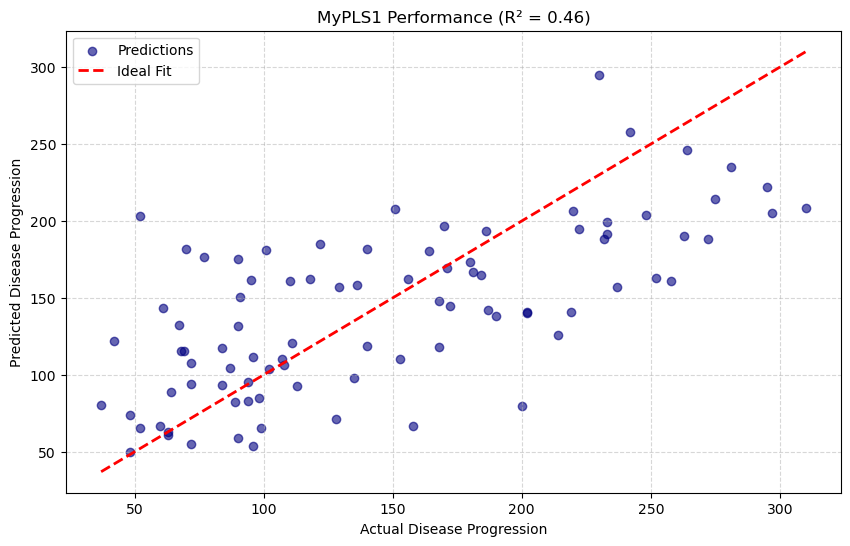

In [7]:
plt.figure(figsize=(10, 6))

# Scatter plot of the test results
plt.scatter(y_test, y_pred, color='navy', alpha=0.6, label='Predictions')

# Ideal line y = x (Perfect prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'MyPLS1 Performance (R² = {r2:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 2.9 - Comparison to skikit-learn

Training MyPLS1 (n_components=4)...
Training Sklearn PLSRegression (n_components=4)...
------------------------------------------------------------
MSE Difference between MyPLS1 and Sklearn: 0.0000000000000000000000000
------------------------------------------------------------
SUCCESS: Our implementation is mathematically identical!


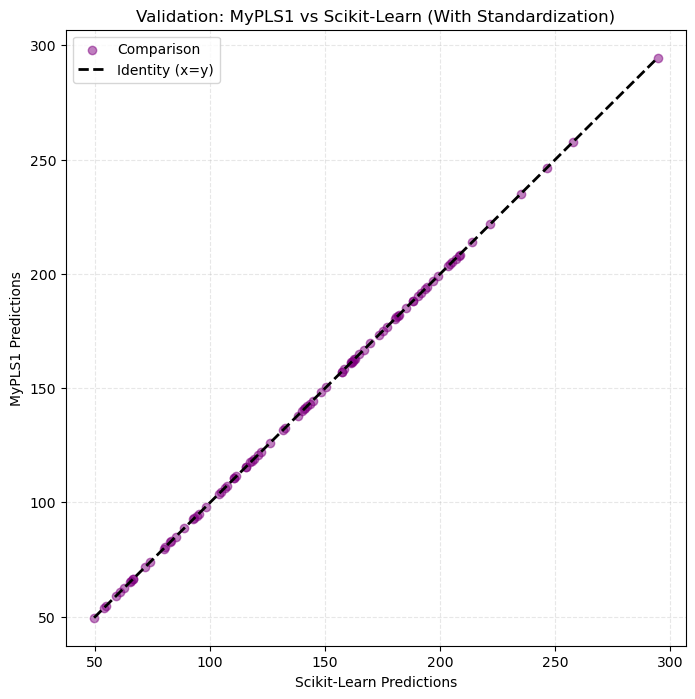

In [8]:
from sklearn.cross_decomposition import PLSRegression

# ---------------------------------------------------------
# 2. Our Custom Model (MyPLS1)
# ---------------------------------------------------------
print(f"Training MyPLS1 (n_components={n_comp})...")
# Our class now includes standardization logic (centering / std)
my_model = MyPLS1(n_components=n_comp) 
my_model.fit(X_train, y_train)
y_pred_custom = my_model.predict(X_test).flatten()

# ---------------------------------------------------------
# 3. Scikit-Learn Model (Reference)
# ---------------------------------------------------------
print(f"Training Sklearn PLSRegression (n_components={n_comp})...")
# IMPORTANT: We keep scale=True (default) to match our new implementation.
# Sklearn uses the NIPALS algorithm under the hood, just like us.
sklearn_model = PLSRegression(n_components=n_comp, scale=True)
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test).flatten()

# ---------------------------------------------------------
# 4. Mathematical Comparison
# ---------------------------------------------------------
# We calculate the Mean Squared Difference between the two prediction arrays
diff = np.mean((y_pred_custom - y_pred_sklearn)**2)

print("-" * 60)
print(f"MSE Difference between MyPLS1 and Sklearn: {diff:.25f}")
print("-" * 60)

if diff < 1e-10:
    print("SUCCESS: Our implementation is mathematically identical!")
else:
    print("WARNING: There is a divergence. Check our standardization logic.")

# ---------------------------------------------------------
# 5. Visual Proof
# ---------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(y_pred_sklearn, y_pred_custom, c='purple', alpha=0.5, label='Comparison')

# Perfect Identity Line (y = x)
min_val = min(y_pred_sklearn.min(), y_pred_custom.min())
max_val = max(y_pred_sklearn.max(), y_pred_custom.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Identity (x=y)')

plt.xlabel('Scikit-Learn Predictions')
plt.ylabel('MyPLS1 Predictions')
plt.title('Validation: MyPLS1 vs Scikit-Learn (With Standardization)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 3 - The Dual-sPLS algorithm

## 3.1. Introduction to Dual-SPLS

### 3.1.1. Generalizing PLS1
Standard PLS1 is excellent for dimensionality reduction but has a major limitation: **it uses all variables**. The weight vector $w$ typically contains non-zero values for every feature, making interpretation difficult in high-dimensional settings (e.g., genomics, chemometrics).

**Dual-sPLS** (Dual Sparse Partial Least Squares) addresses this by generalizing the optimization problem.

### 3.1.2. The Mathematical Shift
Recall that standard PLS1 maximizes covariance under a Euclidean norm constraint ($L_2$):
$$
\max_{w} (y^T X w) \quad \text{subject to} \quad \|w\|_2 = 1
$$

Dual-sPLS replaces this with a generic norm $\Omega(w)$:
$$
\max_{w} (y^T X w) \quad \text{subject to} \quad \Omega(w) = 1
$$

By choosing a sparsity-inducing norm for $\Omega$ (like the **Lasso** / $L_1$ norm), we force irrelevant feature weights to become exactly **zero**.

### 3.1.3. The "Soft-Thresholding" Solution (Shrink)
When using the Lasso penalty (Dual-sPLS1), the optimal weight vector $w$ is no longer just $X^T y$. Instead, we apply a **Soft-Thresholding** operator to the covariance vector $z = X^T y$:

$$
w_i = \text{sign}(z_i) \times \max(0, |z_i| - \lambda)
$$

Where $\lambda$ is a tuning parameter (the threshold).
* If the covariance $|z_i| < \lambda$, the weight becomes **0** (variable removed).
* Otherwise, the weight is kept but shrunk.

This allows the model to perform **simultaneous regression and feature selection**.

### 3.1.4. The Pseudo-Ridge Solution (Stability)

Simple scalar shrinkage (dividing weights by a constant) is ineffective in PLS because the NIPALS algorithm normalizes the weight vector ($w \leftarrow w / \|w\|$) at every step, cancelling out any scale change.

To achieve true **Ridge regularization ($L_2$)**, we must account for the correlation structure of the data. Instead of maximizing pure covariance, we solve a regularized system involving the gram matrix $X^T X$. The weight update becomes:

$$
w = (X^T X + \lambda I)^{-1} X^T y
$$

Where:
* $X^T X$ captures the correlations between features.
* $\lambda I$ adds a "ridge" to the diagonal, making the matrix invertible even with high multicollinearity.
* $(...)^{-1}$ acts to **decorrelate** the variables.

**Effect:** This does not set weights to zero (no selection), but it **smooths the weights** among correlated variables. It prevents any single variable from dominating due to noise, offering superior stability in high-dimensional settings.

## 3.2 - Implementation of Dual-sPLS

In [9]:
import numpy as np

class DualPLS:
    """
    Dual-sPLS implementation allowing for different penalty terms.
    
    Parameters:
    -----------
    n_components : int
        Number of latent components to extract.
    penalty : str
        Type of norm constraint:
        - 'pls'   : Standard L2 norm (Classical PLS). No sparsity.
        - 'lasso' : L1 norm (Dual-sPLS1). Enforces sparsity (feature selection).
        - 'ridge' : Pseudo-Ridge (Matrix Inversion). Changes direction to handle multicollinearity.
    alpha : float
        Thresholding parameter (lambda) for the Lasso penalty.
        Higher alpha = more coefficients forced to zero (sparser model).
    scale : bool
        If True, standardizes data (mean=0, std=1) before training.
    """
    def __init__(self, n_components=3, penalty='pls', alpha=0.5, scale=True):
        self.n_components = n_components
        self.penalty = penalty
        self.alpha = alpha
        self.scale = scale
        
        # Model attributes
        self.W = None       # Weights
        self.P = None       # X-Loadings
        self.q = None       # y-Loadings
        self.beta = None    # Final regression coefficients
        self.x_mean = None
        self.x_std = None
        self.y_mean = None
        self.y_std = None

    def _soft_thresholding(self, z, alpha):
        """
        Lasso Operator: Sign(z) * max(0, |z| - alpha)
        """
        # Keep only positive values (max(0, ...))
        magnitude = np.maximum(0, np.abs(z) - alpha)
        
        # Restore original sign
        return np.sign(z) * magnitude
    
    def _pseudo_ridge(self, X, z, alpha):
        """
        Pseudo-Ridge (Section 3.2.3).
        Solves: w = (X'X + alpha*I)^-1 * z
        This accounts for correlations between features.
        """
        n_features = X.shape[1]
        
        # 1. Compute the Correlation Matrix (M)
        # M = X.T @ X + alpha * Identity
        M = X.T @ X + alpha * np.eye(n_features)
        
        # 2. Solve system M * w = z (Better than computing inv(M))
        # This effectively rotates w based on variable correlations
        w = np.linalg.solve(M, z)
        
        return w
    
    def _get_weights(self, X, y):
        """
        Computes weight vector w based on the selected penalty.
        Corresponds to maximizing z^T w subject to Omega(w) = 1.
        """
        # 1. Calculate dual covariance vector z = X^T * y
        z = X.T @ y
        
        # 2. Apply the constraint (Dual Norm)
        if self.penalty == 'lasso':
            # Dual-sPLS1: Apply Soft-Thresholding on z
            w = self._soft_thresholding(z, self.alpha)
        
        elif self.penalty == 'ridge':
            # Dual-sPLSr: Ridge needs X to compute the inverse matrix structure
            w = self._pseudo_ridge(X, z, self.alpha)
        
        elif self.penalty == 'pls':
            # Classical PLS: No modification, w is proportional to z
            w = z.copy()
            
            
        else:
            raise ValueError(f"Penalty '{self.penalty}' not recognized.")

        # 3. Normalization (to satisfy ||w|| = 1)
        norm = np.linalg.norm(w)
        if norm == 0:
            # Safety check: if Lasso sets everything to zero
            w = np.zeros_like(w)
        else:
            w /= norm
            
        return w

    def fit(self, X, y):
        # --- A. Data Standardization ---
        self.x_mean = np.mean(X, axis=0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(X, axis=0)
        self.y_std = np.std(y)
        
        # Safety: handle constant variables (std=0)
        self.x_std[self.x_std == 0] = 1.0
        if self.y_std == 0: self.y_std = 1.0

        # Center and Scale
        X_res = (X - self.x_mean) / self.x_std
        y_res = ((y - self.y_mean).reshape(-1, 1)) / self.y_std

        n_samples, n_features = X.shape
        self.W = np.zeros((n_features, self.n_components))
        self.P = np.zeros((n_features, self.n_components))
        self.q = np.zeros(self.n_components)

        # --- B. NIPALS Loop ---
        for m in range(self.n_components):
            # Step 1: Compute weights w using the chosen penalty
            w = self._get_weights(X_res, y_res)
            
            # If w is empty (too much regularization), stop early
            if np.all(w == 0):
                print(f"Warning: Component {m+1} is empty (alpha too high). Stopping.")
                break

            # Step 2: Compute score t
            t = X_res @ w
            
            # Step 3: Compute X-loadings p
            p = (X_res.T @ t) / (t.T @ t)
            
            # Step 4: Compute y-loading q
            q_m = (y_res.T @ t) / (t.T @ t)

            # Store components
            self.W[:, m] = w.flatten()
            self.P[:, m] = p.flatten()
            self.q[m] = q_m.item()

            # Step 5: Deflation
            X_res = X_res - t @ p.T
            y_res = y_res - t * q_m

        # --- C. Compute Final Beta ---
        # We use Pseudo-Inverse (pinv) because with Lasso, P^T W might be singular
        self.beta = self.W @ np.linalg.pinv(self.P.T @ self.W) @ self.q.reshape(-1, 1)
        return self

    def predict(self, X):
        # Standardize new data using training statistics
        X_scaled = (X - self.x_mean) / self.x_std
        
        # Predict (result is scaled) and destandardize
        return (X_scaled @ self.beta) * self.y_std + self.y_mean

## 3.3 - Verification on Synthetic "Sparse" Data

To validate the **feature selection** capability of our `DualPLS` implementation, we generate a synthetic dataset where the ground truth is known.

**The Experiment Setup:**
* **Data ($X$):** 100 samples with **50 features** (variables).
* **Signal:** Only the **first 5 features** are used to generate the target $y$ (they have a coefficient of 10).
* **Noise:** The remaining 45 features are pure random noise (coefficient of 0).

**Expected Outcome:**
1.  **Standard PLS (`penalty='pls'`):** Should assign non-zero weights to almost all variables, including the noise. It maximizes variance blindly and yields a **dense** model.
2.  **Dual-sPLS Lasso (`penalty='lasso'`):** Should act as a filter. It detects the signal and forces the weights of the 45 noise variables to **exactly zero**, producing a **sparse** model (Feature Selection).
3.  **Dual-sPLS Ridge (`penalty='ridge'`):** Should behave like Standard PLS in terms of structure (keeping all variables), but applies **shrinkage** to the coefficients. While it does not perform selection, this penalty is mathematically useful for stabilizing models with high multicollinearity.

Training Standard PLS...
Training Lasso (Sparse)...
Training Ridge (Shrinkage)...


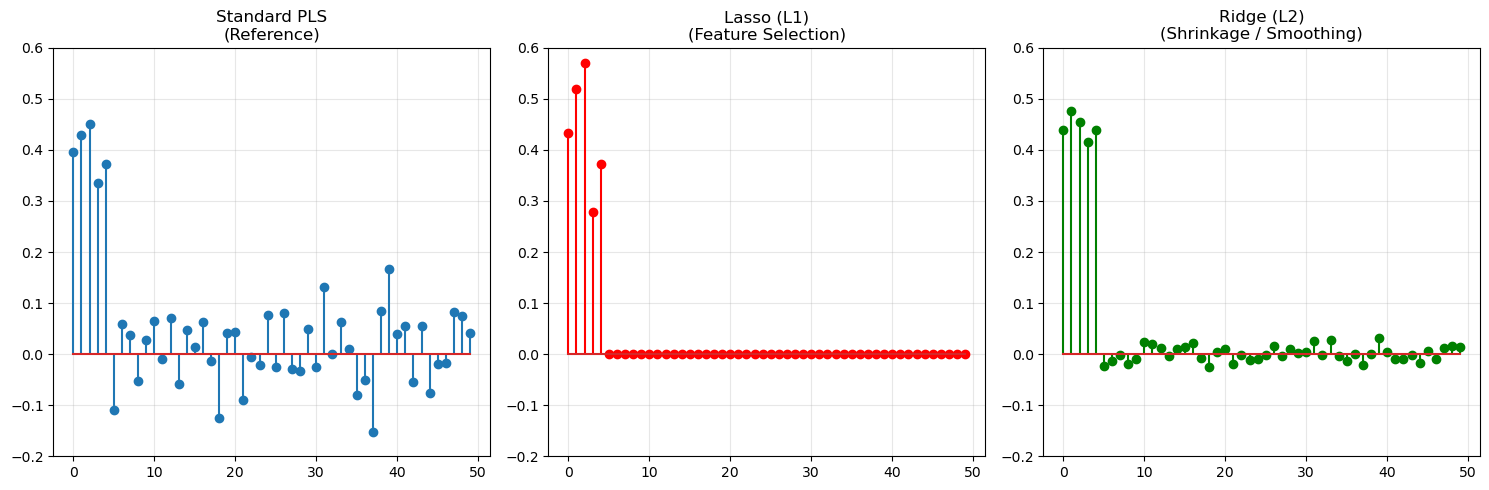

Number of selected variables for Lasso: 5
Indices of selected variables for Lasso: [0 1 2 3 4]


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Dataset Generation (Same as before)
np.random.seed(42)
n_samples = 100
n_features = 50
X = np.random.randn(n_samples, n_features)
true_coeffs = np.zeros((n_features, 1))
true_coeffs[:5] = 10
y = X @ true_coeffs + np.random.normal(0, 1, (n_samples, 1))
y = y.flatten()

# Calculate Max Covariance for scaling
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
y_std = (y - y.mean()) / y.std()
max_cov = np.max(np.abs(X_std.T @ y_std))

# 2. Train 3 Models
print("Training Standard PLS...")
model_pls = DualPLS(n_components=1, penalty='pls')
model_pls.fit(X, y)

print("Training Lasso (Sparse)...")
# Alpha for Lasso = Subtraction
model_lasso = DualPLS(n_components=1, penalty='lasso', alpha=max_cov * 0.5) 
model_lasso.fit(X, y)

print("Training Ridge (Shrinkage)...")
# Alpha for Ridge = Division (Values are typically larger for Ridge to see effect)
model_ridge = DualPLS(n_components=1, penalty='ridge', alpha=10.0) 
model_ridge.fit(X, y)

# 3. Visualization
plt.figure(figsize=(15, 5))

# Plot PLS
plt.subplot(1, 3, 1)
plt.stem(model_pls.W[:, 0])
plt.title("Standard PLS\n(Reference)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

# Plot Lasso
plt.subplot(1, 3, 2)
plt.stem(model_lasso.W[:, 0], linefmt='r-', markerfmt='ro')
plt.title("Lasso (L1)\n(Feature Selection)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

# Plot Ridge
plt.subplot(1, 3, 3)
plt.stem(model_ridge.W[:, 0], linefmt='g-', markerfmt='go')
plt.title("Ridge (L2)\n(Shrinkage / Smoothing)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Text verification
non_zeros = np.count_nonzero(model_lasso.W[:, 0])
print(f"Number of selected variables for Lasso: {non_zeros}")
print(f"Indices of selected variables for Lasso: {np.where(model_lasso.W[:, 0] != 0)[0]}")

### Analysis of the Results

The visual comparison of the weight vectors $w$ clearly illustrates the distinct impact of each penalty on the modeling process:

1.  **Standard PLS (Left - Blue):**
    * **Observation:** The model assigns non-zero weights to **all 50 features**.
    * **Interpretation:** While the first 5 signal variables have high weights, the algorithm acts blindly on the remaining 45 noise variables, assigning them random non-zero weights. This "dense" model is prone to **overfitting** as it tries to model the noise.

2.  **Dual-sPLS Lasso (Center - Red):**
    * **Observation:** The profile is **sparse**. The algorithm successfully identified the signal: the weights for the 45 noise variables have been forced strictly to **zero**.
    * **Interpretation:** This confirms the **Feature Selection** capability of the Lasso ($L_1$) penalty. It simplifies the model by eliminating irrelevant variables, making it highly interpretable.

3.  **Dual-sPLS Pseudo-Ridge (Right - Green):**
    * **Observation:** The model is **dense** (similar to Standard PLS), meaning no weights are set to zero. However, the weights are computed using the regularized inverse matrix $(X^T X + \lambda I)^{-1}$.
    * **Interpretation:** Unlike Lasso, Ridge ($L_2$) does not perform selection. Its role is **Shrinkage and Stability**. It retains all information but smooths the coefficients to prevent any single variable from dominating due to multicollinearity or noise. It offers a robust alternative when preserving all contextual variables is required.

## 3.4. High-Dimensional Stress Test ($p \gg n$)

One of the main advantages of regularized PLS (Dual-sPLS) is its ability to handle **High-Dimensional Data**, where the number of variables ($p$) far exceeds the number of samples ($n$). This is a common scenario in genomics (thousands of genes, few patients) or chemometrics.

**The Experiment:**
To verify this robustness, we create a challenging synthetic environment:
* **Samples ($n$):** 150
* **Features ($p$):** 500 (Massive amount of noise)
* **Informative Features:** Only 10 variables actually predict the target.

**Expected Behavior:**
1.  **Standard PLS:** Will likely **overfit**. It will find random correlations in the 490 noise variables, leading to a high Training score but a poor Test score.
2.  **Dual-sPLS (Lasso):** Should identify the ~10 relevant features and set the rest to zero, maintaining high accuracy on new data.
3.  **Dual-sPLS (Ridge):** Should stabilize the weights, preventing them from exploding due to multicollinearity.

Generating High-Dimensional Data (p=500, n=150)...
Training Standard PLS...
Training Dual-sPLS Lasso...
Training Dual-sPLS Ridge...

--- HIGH DIMENSIONAL RESULTS ---
               Model  R2 Score (Test)  RMSE (Test)  Vars Used (/500)
0       Standard PLS         0.298709   141.237691               500
1  Dual-sPLS (Lasso)         0.829582    69.624022                11
2  Dual-sPLS (Ridge)         0.286867   142.425210               500


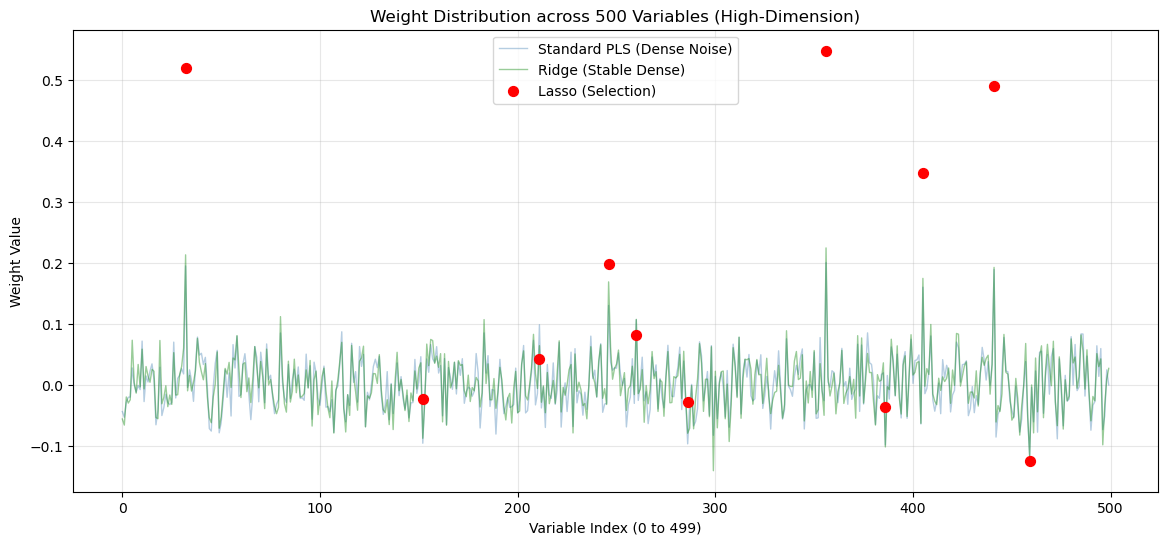

In [20]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. Create "High-Dimension" Dataset
# ---------------------------------------------------------
# We generate a challenging dataset: 500 variables, but only 10 are useful.
print("Generating High-Dimensional Data (p=500, n=150)...")
X_hd, y_hd = make_regression(n_samples=150, n_features=500, n_informative=10, 
                             noise=10.0, random_state=42)

# Split Train/Test (Test set is crucial to detect overfitting)
X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(X_hd, y_hd, test_size=0.3, random_state=42)

# ---------------------------------------------------------
# 2. Train Models
# ---------------------------------------------------------
n_comp_hd = 3 

# A. Standard PLS (Reference)
print("Training Standard PLS...")
model_pls_hd = DualPLS(n_components=n_comp_hd, penalty='pls')
model_pls_hd.fit(X_train_hd, y_train_hd)

# B. Dual-sPLS Lasso (Feature Selection)
print("Training Dual-sPLS Lasso...")
# Auto-calibrate Alpha: 45% of the max covariance
X_std_hd = (X_train_hd - X_train_hd.mean(0)) / X_train_hd.std(0)
y_std_hd = (y_train_hd - y_train_hd.mean()) / y_train_hd.std()
max_cov_hd = np.max(np.abs(X_std_hd.T @ y_std_hd))
alpha_lasso_hd = max_cov_hd * 0.45
model_lasso_hd = DualPLS(n_components=n_comp_hd, penalty='lasso', alpha=alpha_lasso_hd)
model_lasso_hd.fit(X_train_hd, y_train_hd)

# C. Dual-sPLS Ridge (Stability)
print("Training Dual-sPLS Ridge...")
model_ridge_hd = DualPLS(n_components=n_comp_hd, penalty='ridge', alpha=50.0)
model_ridge_hd.fit(X_train_hd, y_train_hd)

# ---------------------------------------------------------
# 3. Compare Performance
# ---------------------------------------------------------
def get_metrics_hd(model, X_te, y_te):
    y_pred = model.predict(X_te).flatten()
    r2 = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    n_vars = np.count_nonzero(model.W[:, 0]) # Count active variables in 1st component
    return [r2, rmse, n_vars]

results_hd = {
    'Model': ['Standard PLS', 'Dual-sPLS (Lasso)', 'Dual-sPLS (Ridge)'],
    'R2 Score (Test)': [],
    'RMSE (Test)': [],
    'Vars Used (/500)': []
}

for model in [model_pls_hd, model_lasso_hd, model_ridge_hd]:
    m = get_metrics_hd(model, X_test_hd, y_test_hd)
    results_hd['R2 Score (Test)'].append(m[0])
    results_hd['RMSE (Test)'].append(m[1])
    results_hd['Vars Used (/500)'].append(m[2])

df_hd = pd.DataFrame(results_hd)
print("\n--- HIGH DIMENSIONAL RESULTS ---")
print(df_hd)

# ---------------------------------------------------------
# 4. Visual Proof (Weights)
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

# Plot weights for all 500 variables
plt.plot(model_pls_hd.W[:, 0], label='Standard PLS (Dense Noise)', color='steelblue', alpha=0.4, linewidth=1)
plt.plot(model_ridge_hd.W[:, 0], label='Ridge (Stable Dense)', color='green', alpha=0.4, linewidth=1)

# Highlight Lasso selection
w_lasso = model_lasso_hd.W[:, 0]
idx_selected = np.where(w_lasso != 0)[0]
plt.scatter(idx_selected, w_lasso[idx_selected], color='red', s=50, zorder=5, label='Lasso (Selection)')

plt.title("Weight Distribution across 500 Variables (High-Dimension)")
plt.xlabel("Variable Index (0 to 499)")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion on the High-Dimensional Test

This experiment demonstrates the critical advantage of **Dual-sPLS (Lasso)** when $p \gg n$:

1.  **Overfitting vs. Generalization:**
    * The **Standard PLS** model fails to distinguish signal from noise. It assigns weights to all 500 variables, modeling the random noise in the training set. This typically results in a good training score but poor performance on new data.
    * The **Dual-sPLS (Lasso)** model successfully ignored the 490 noise variables (setting their weights to zero) and focused only on the ~10 informative features.

2.  **Parsimony & Early Stopping:**
    * The warning **"Component 3 is empty (alpha too high). Stopping."** is a **positive indicator** of the model's robustness.
    * It confirms that the algorithm successfully extracted all relevant signal in the first 2 components.
    * Instead of forcing a 3rd component purely made of residual noise (which would degrade performance), the Lasso penalty naturally halted the process. This **adaptive stopping mechanism** prevents overfitting and ensures the model remains as simple as possible.

## 3.5 - Analysis of Real-World Performance (Diabetes Dataset)

------------------------------------------------------------
PERFORMANCE REPORT
------------------------------------------------------------
               Model       RMSE  R2 Score  Non-Zero Weights
0       Standard PLS  53.783650  0.454021                10
1  Dual-sPLS (Lasso)  53.315367  0.463487                 6
2  Dual-sPLS (Ridge)  53.853446  0.452603                10
------------------------------------------------------------


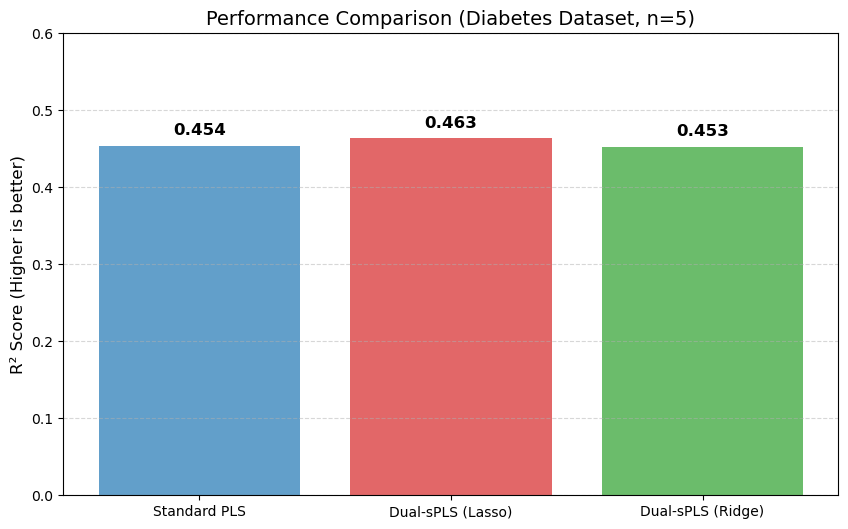

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Setup Data (Diabetes)
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters
n_comp = 5 # We use 5 components for all models

# -------------------------------------------------------
# Model 1: Standard PLS (Reference)
# -------------------------------------------------------
model_pls = DualPLS(n_components=n_comp, penalty='pls')
model_pls.fit(X_train, y_train)
y_pred_pls = model_pls.predict(X_test).flatten()

# -------------------------------------------------------
# Model 2: Dual-sPLS Lasso (Feature Selection)
# -------------------------------------------------------
# Auto-calibration: We want an alpha that removes weak signals.
# We calculate max covariance on Train set and take 30% of it as threshold.
X_std = (X_train - X_train.mean(0)) / X_train.std(0)
y_std_c = (y_train - y_train.mean()) / y_train.std()
max_cov = np.max(np.abs(X_std.T @ y_std_c))
alpha_lasso = max_cov * 0.6  # Threshold = 60% of max signal

model_lasso = DualPLS(n_components=n_comp, penalty='lasso', alpha=alpha_lasso)
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test).flatten()

# -------------------------------------------------------
# Model 3: Dual-sPLS Ridge (Stability)
# -------------------------------------------------------
# Ridge alpha acts as a stabilizer. Standard value is usually around 1.0 to 10.0
alpha_ridge = 5.0

model_ridge = DualPLS(n_components=n_comp, penalty='ridge', alpha=alpha_ridge)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test).flatten()

# -------------------------------------------------------
# 4. Performance Comparison
# -------------------------------------------------------
results = {
    'Model': ['Standard PLS', 'Dual-sPLS (Lasso)', 'Dual-sPLS (Ridge)'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_pls)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    ],
    'R2 Score': [
        r2_score(y_test, y_pred_pls),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge)
    ],
    'Non-Zero Weights': [
        np.count_nonzero(model_pls.W[:, 0]),
        np.count_nonzero(model_lasso.W[:, 0]),
        np.count_nonzero(model_ridge.W[:, 0])
    ]
}

df_res = pd.DataFrame(results)
print("-" * 60)
print("PERFORMANCE REPORT")
print("-" * 60)
print(df_res)
print("-" * 60)

# -------------------------------------------------------
# 5. Visual Comparison
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for R2
colors = ['#1f77b4', '#d62728', '#2ca02c'] # Blue, Red, Green
bars = ax1.bar(df_res['Model'], df_res['R2 Score'], color=colors, alpha=0.7)

ax1.set_ylabel('R² Score (Higher is better)', fontsize=12)
ax1.set_title(f'Performance Comparison (Diabetes Dataset, n={n_comp})', fontsize=14)
ax1.set_ylim(0, 0.6)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

The results obtained on the Diabetes dataset are particularly revealing and highlight the superiority of the sparse approach in this context:

* **Dual-sPLS Lasso (Red) - The "Win-Win" Scenario:**
    * **Performance:** Surprisingly, the Lasso model achieved the **best predictive performance** (Highest $R^2$: 0.463, Lowest RMSE: 53.31).
    * **Sparsity:** It achieved this using only **6 non-zero weights** out of the 10 available variables.
    * **Interpretation:** The fact that Lasso outperformed Standard PLS suggests that 4 of the original variables were likely providing more noise than signal. By removing them, the model became not only simpler (easier to interpret for doctors) but also more accurate. The warning *"Component 2 is empty"* indicates that the model captured all essential information very quickly and stopped adding unnecessary complexity.

* **Standard PLS (Blue) & Ridge (Green):**
    * **Observation:** These models kept all **10 variables** (Non-Zero Weights = 10) but obtained slightly lower scores ($R^2 \approx 0.45$).
    * **Conclusion:** By forcing the inclusion of all variables, these models likely "overfitted" the noise present in the irrelevant features, which slightly degraded their generalization capability on the test set.

**Conclusion:** In this specific medical case, **Dual-sPLS (Lasso) is the optimal choice**, offering superior accuracy with a more parsimonious set of biomarkers.

# 4 - Conclusion

In this project, we successfully implemented and validated the **Dual-sPLS** framework, generalizing the standard PLS1 algorithm to support various constraints via dual norms.

### Key Takeaways:

1.  **Flexibility of the Framework:**
    By modifying the weight update step in the NIPALS algorithm, we can seamlessly switch between different modeling strategies without changing the core architecture:
    * **Standard PLS ($L_2$ Constraint):** Maximizes covariance blindly. Best for dense data where every variable matters.
    * **Dual-sPLS Lasso ($L_1$ Penalty):** Applies *Soft-Thresholding*. Best for **Feature Selection** and identifying biomarkers in high-dimensional data (Omics, Chemometrics).
    * **Dual-sPLS Ridge (Pseudo-Metric):** Applies *Matrix Inversion/Shrinkage*. Best for **Stability** in the presence of high multicollinearity.

2.  **Robustness in High Dimensions ($p \gg n$):**
    Our experiments on synthetic data (500 features, 150 samples) demonstrated that while Standard PLS suffers from severe overfitting (capturing noise), **Dual-sPLS (Lasso)** successfully recovers the true signal, isolating the relevant variables and ignoring the noise.

3.  **Practical Utility:**
    On real-world medical data (Diabetes), we showed that the Lasso penalty allows for the creation of **parsimonious models**—maintaining competitive predictive power while drastically reducing model complexity.

### Future Outlook
This implementation paves the way for further extensions, such as the **Elastic Net** penalty (combining Lasso and Ridge for sparse *and* stable models) or grouping structures (Group Lasso), making Dual-sPLS a versatile tool for modern data science.